<a href="https://colab.research.google.com/github/kushalnavghare/Real-or-not-Kaggle/blob/master/real-or-not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kushalnavghare/Real-or-not-Kaggle.git

Cloning into 'Real-or-not-Kaggle'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [2]:
%cd Real-or-not-Kaggle/

/content/Real-or-not-Kaggle


In [3]:
%ll

total 724
-rw-r--r-- 1 root   1072 Sep 13 16:19 LICENSE
-rw-r--r-- 1 root 607343 Sep 13 16:19 nlp-getting-started.zip
-rw-r--r-- 1 root     63 Sep 13 16:19 README.md
-rw-r--r-- 1 root 122560 Sep 13 16:19 real-or-not.ipynb


In [4]:
!unzip nlp-getting-started.zip -d data

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [5]:
ll data

total 1404
-rw-r--r-- 1 root  22746 Dec 16  2019 sample_submission.csv
-rw-r--r-- 1 root 420783 Dec 16  2019 test.csv
-rw-r--r-- 1 root 987712 Dec 16  2019 train.csv


In [6]:
pwd

'/content/Real-or-not-Kaggle'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [8]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

subm_data = pd.read_csv('data/sample_submission.csv')

In [9]:
train_data.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [10]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


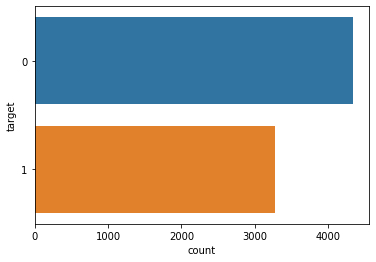

In [11]:
sns.countplot(y = train_data.target)

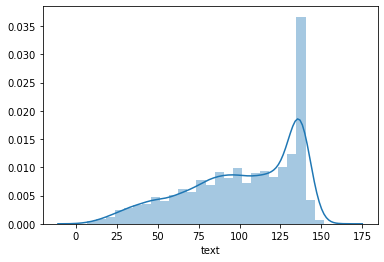

In [12]:
sns.distplot(train_data.text.str.len(), label='Average Text Length')

In [13]:
most_freq_words = pd.Series(" ".join(train_data['text']).split()).value_counts()

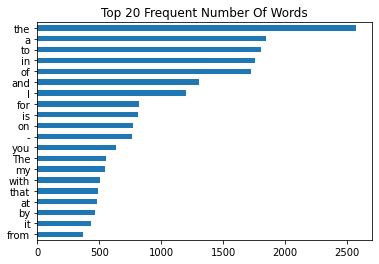

In [14]:
most_freq_words.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Number Of Words")

Lets look into Bi-Grams and what are those.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')

In [17]:
sparse_matrix = word_vectorizer.fit_transform(train_data["text"])
frequencies = sum(sparse_matrix).toarray()[0]
bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])



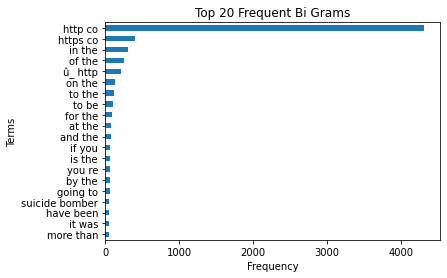

In [18]:
plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_bigrams = bi_grams_df["frequency"].sort_values(ascending = False).head(20)

top20_bigrams.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Bi Grams")

Looks like a lot of stopwords, punctuation and http links are present in the data. MUST REMOVE IT!!

**Text Cleaning**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

In [20]:
# To lower case text
train_data['text'] = train_data.text.str.lower()

In [21]:
# remove stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

In [23]:
tokenized_doc = train_data['text'].apply(lambda x: x.split())

In [24]:
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [25]:
train_data['clean_text'] = tokenized_doc.astype(str).str.replace('\[|\]|\'', '')
train_data['clean_text'] = train_data.clean_text.str.replace(",",'')

In [26]:
train_data['clean_text'] = train_data.clean_text.str.replace(r'[^\w\s]', '')

In [27]:
train_data.head(2)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada


In [28]:
def top_n_words(text, n):
    
    most_freq_words = pd.Series(" ".join(text).split()).value_counts()
    return most_freq_words.head(n).sort_values(ascending = True).plot(kind="barh",title = "Top {n} Frequent Number Of Words".format(n = n))

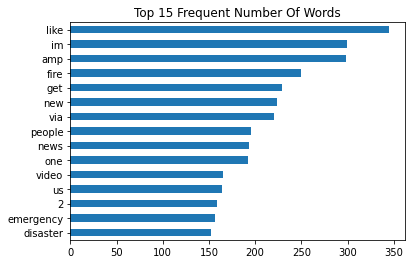

In [29]:
top_n_words(train_data.clean_text, 15)

In [30]:
# Remove numbers from the text
train_data.clean_text.str.replace('\d+', '')

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610             m  utckm volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: clean_text, Length: 7613, dtype: object

In [31]:
# Remove URLs
train_data['clean_text'] = train_data.clean_text.apply(lambda x: re.sub(r"http\S+", "", str(x)))

# Remove numbers
train_data['clean_text'] = train_data.clean_text.str.replace('\d+', '')
# re.sub(r'https?:\/\/.*[\r\n]*', '', str(train_data.clean_text))

In [32]:
train_data.head(2)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada


In [33]:
# train test split
target = train_data['target']
    
x_train, x_test, y_train, y_test = train_test_split(train_data['clean_text'], target, test_size=0.30, random_state=100)

In [34]:
# Feature extraction

vectorizer = CountVectorizer(max_df = 0.7, max_features=1000)

In [35]:
train_df = vectorizer.fit_transform(x_train.values.astype('U'))
    
test_df = vectorizer.transform(x_test.values.astype('U'))

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
model = LogisticRegression()

In [38]:
model.fit(train_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
model.predict(test_df)

array([1, 0, 1, ..., 0, 0, 1])

In [40]:
from sklearn.metrics import precision_recall_curve

In [41]:
# prediction on test samples

preds1 = pd.DataFrame(model.predict_proba(test_df), 
                     # index=X_test_post_encoding.index, 
                     columns= ['prob_0', 'prob_1'])
# test_df = pd.concat([X_test_post_encoding, y_test, preds], axis = 1)

In [42]:
# precision recall curve

lr_precision1, lr_recall1, _1 = precision_recall_curve(y_true = y_test, probas_pred = preds1.prob_1)

Text(0.5, 1.0, 'Precision-Recall Curve - LogisticRegression')

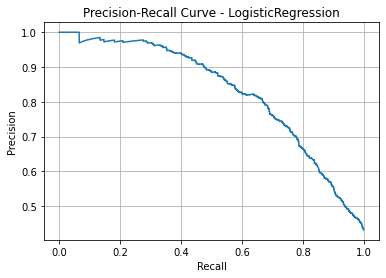

In [43]:
# Precision recall curve

plt.plot(lr_recall1, lr_precision1)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LogisticRegression')

In [44]:
test_data.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


In [49]:
from xgboost import XGBClassifier

In [70]:
xgb_model = XGBClassifier(n_estimators=800, max_depth=4, learning_rate=.01)

In [71]:
xgb_model.fit(train_df, y_train, eval_metric='logloss', eval_set=[(test_df, y_test)])

[0]	validation_0-logloss:0.692365
[1]	validation_0-logloss:0.69157
[2]	validation_0-logloss:0.690781
[3]	validation_0-logloss:0.690018
[4]	validation_0-logloss:0.689303
[5]	validation_0-logloss:0.688555
[6]	validation_0-logloss:0.687843
[7]	validation_0-logloss:0.687134
[8]	validation_0-logloss:0.686433
[9]	validation_0-logloss:0.68576
[10]	validation_0-logloss:0.685092
[11]	validation_0-logloss:0.684425
[12]	validation_0-logloss:0.683785
[13]	validation_0-logloss:0.683125
[14]	validation_0-logloss:0.682501
[15]	validation_0-logloss:0.681891
[16]	validation_0-logloss:0.681279
[17]	validation_0-logloss:0.680667
[18]	validation_0-logloss:0.680183
[19]	validation_0-logloss:0.679592
[20]	validation_0-logloss:0.679082
[21]	validation_0-logloss:0.678488
[22]	validation_0-logloss:0.678023
[23]	validation_0-logloss:0.677485
[24]	validation_0-logloss:0.677002
[25]	validation_0-logloss:0.676461
[26]	validation_0-logloss:0.676015
[27]	validation_0-logloss:0.675484
[28]	validation_0-logloss:0.6749

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [72]:
xgb_df = pd.DataFrame(xgb_model.predict_proba(test_df), columns=['xgb_0', 'xgb_1'])

In [73]:
result_preds = pd.concat([xgb_df, preds1], axis=1)

In [74]:
lr_precision2, lr_recall2, _2 = precision_recall_curve(y_true=y_test, probas_pred = xgb_df.xgb_1)

Text(0.5, 1.0, 'Precision-Recall Curve')

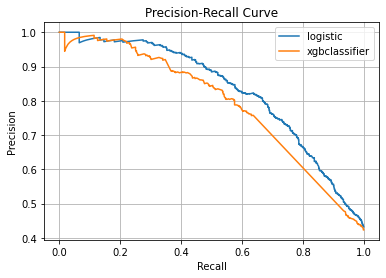

In [75]:
# Precision recall curve

plt.plot(lr_recall1, lr_precision1, label='logistic')
plt.plot(lr_recall2, lr_precision2, label='xgbclassifier')
plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')